# Prepare data for validation of CNN CHMs  
footprint predicted CHMs  
map footprints  
select subset of CHMs based on footprint intersection with TTE polygons  



In [1]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show

import fiona
import geopandas as gpd
import pandas as pd
import numpy as np

import contextily as ctx

import os
import sys
import glob
sys.path.append('/home/pmontesa/code/pygeotools')
from pygeotools.lib import *

sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import vhrlib
import maplib

# This is a private repo
sys.path.append('/home/pmontesa/code/dgtools')
from dgtools.lib import dglib

# 
sys.path.append('/home/pmontesa/code/above-shrubs')
import notebooks.predlib

import random
import shapely
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plotnine
from plotnine import *

/tmp/ipykernel_3334013/1655321929.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
import importlib
importlib.reload(footprintlib)

<module 'footprintlib' from '/home/pmontesa/code/geoscitools/footprintlib.py'>

In [3]:
from multiprocessing import Pool
from functools import partial

### Paths

In [53]:
OUT_SUBDIR = 'cnn-chm-v2-noAug-invSqrt'
dir_main = '/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/products'
dir_chm = f'{dir_main}/{OUT_SUBDIR}'
dir_footprints = f'{dir_main}/footprints'
print(f'Path to current set of CHM predictions:\n{dir_chm}')

Path to current set of CHM predictions:
/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/products/cnn-chm-v2-noAug-invSqrt


### Footprint the predictions

In [ ]:
pred_fn_list = glob.glob(dir_chm + '/**/*cnn-chm-v1.tif')

In [5]:
%%time
with Pool(processes=35) as pool:
    f_gdf_lst = pool.map(partial(footprintlib.raster_footprint, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True), pred_fn_list)

CPU times: user 39.4 ms, sys: 191 ms, total: 230 ms
Wall time: 523 ms


In [6]:
footprint_gdf_preds = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME='CHM pred stack', DROP_DUPLICATES=True)
footprint_gdf_preds = footprintlib.get_attributes_from_filename(footprint_gdf_preds, 'CHM', '-sr')
footprint_gdf_preds.info()

Building GDF from list...
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 83 entries, 0 to 82
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   file            83 non-null     object  
 1   geometry        83 non-null     geometry
 2   footprint_name  83 non-null     object  
 3   path            83 non-null     object  
 4   area_km2        83 non-null     float64 
 5   area_ha         83 non-null     float64 
 6   type            83 non-null     object  
 7   catid           83 non-null     object  
 8   sensor          83 non-null     object  
 9   year            83 non-null     int64   
 10  month           83 non-null     int64   
dtypes: float64(2), geometry(1), int64(2), object(6)
memory usage: 7.8+ KB


### Subset set of preds to July, August

In [7]:
# Subset
footprint_gdf_preds = footprint_gdf_preds[(footprint_gdf_preds.month==7)|(footprint_gdf_preds.month==8)]

### Map current set of CNN CHM predictions from SRLite + DTM

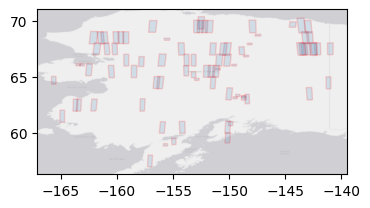

In [8]:
ax_main = footprint_gdf_preds[(footprint_gdf_preds.month==7)|(footprint_gdf_preds.month==8)].plot(figsize=(4,4), alpha=0.15, ec='red')
ax_main = ctx.add_basemap(ax_main, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas, attribution=' ' ) #Esri.NatGeoWorldMap. Esri.WorldGrayCanvas Esri.WorldImagery

## Select some geo-domain to subset predictions

##### Get landscapes with sparse forests - appropriate for ABoVE Shrubs study
using TTE map from Montesano et al 2020  
https://iopscience.iop.org/article/10.1088/1748-9326/abb2c7

In [9]:
tte_patterns_fn = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/boreal_height_cmip/hydrobasins_L08_patterns_tte.gpkg'
tte_patterns = gpd.read_file(tte_patterns_fn)

In [54]:
tte_patterns_abrupt = tte_patterns[(tte_patterns.pattern_class == 'TTE abrupt') | (tte_patterns.pattern_class == 'TTE abrupt (edge)')]
#footprint_gdf_stacks_TTE = gpd.overlay(footprint_gdf_stacks.to_crs(4326), tte_patterns_abrupt, how='intersection')

In [38]:
# Buffer TTE abrupt landscapes by 
BUF_SZ_M = 500e3
SUBSET_TYPE = f'tte-abrupt-cavm-buf{int(BUF_SZ_M/1e3)}km'
SUBSET_TYPE

'tte-abrupt-cavm-buf500km'

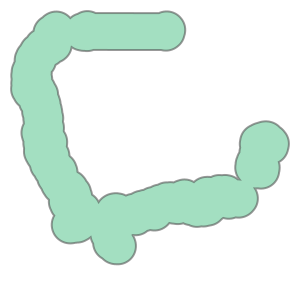

In [11]:
tte_patterns_abrupt_cavm_geom = tte_patterns_abrupt.to_crs(3338).dissolve(by='cavm').iloc[0].geometry.buffer(BUF_SZ_M)
tte_patterns_abrupt_cavm_geom

##### Subset prediction stacks by TTE abrupt landscapes are associated with the CAVM treeline

In [12]:
selector = footprint_gdf_preds.to_crs(3338).intersects(tte_patterns_abrupt_cavm_geom)
footprint_gdf_preds_SUBSET = footprint_gdf_preds.to_crs(3338)[selector]
footprint_gdf_preds_SUBSET.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 83 entries, 0 to 82
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   file            83 non-null     object  
 1   geometry        83 non-null     geometry
 2   footprint_name  83 non-null     object  
 3   path            83 non-null     object  
 4   area_km2        83 non-null     float64 
 5   area_ha         83 non-null     float64 
 6   type            83 non-null     object  
 7   catid           83 non-null     object  
 8   sensor          83 non-null     object  
 9   year            83 non-null     int64   
 10  month           83 non-null     int64   
dtypes: float64(2), geometry(1), int64(2), object(6)
memory usage: 7.8+ KB


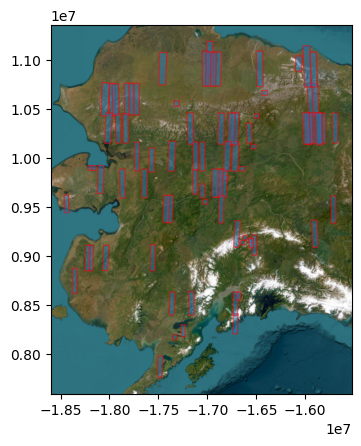

In [13]:
ax = footprint_gdf_preds_SUBSET.to_crs(3857).plot(ec='red', alpha=0.5)
ax = ctx.add_basemap(ax, crs=3857, source = ctx.providers.Esri.WorldImagery, attribution=' ')

In [14]:
# footprint_gdf_preds_TTE[footprint_gdf_preds_TTE['file'].str.contains("3103B100")].explore(style_kwds={'color':'red', 'fillColor':'gray', 'fillOpacity':0.25}, tiles=ctx.providers.Esri.WorldImagery, width=1500, height=400)
# footprint_gdf_preds_TTE[footprint_gdf_preds_TTE['file'].str.contains("3103B100")].path.to_list()

In [15]:
#footprint_gdf_preds_SUBSET.explore(style_kwds={'color':'red', 'fillColor':'gray', 'fillOpacity':0.25}, tiles=ctx.providers.Esri.WorldImagery, width=1500, height=400)

### Save the gdf of subsetted prediction stack footprints

In [16]:
if False:
    footprint_gdf_preds_SUBSET.to_file(f'{dir_footprints}/footprints_{OUT_SUBDIR}.gpkg')

## Find stacks intersection with LVIS footprints for validation

#### Get LVIS footprrints

In [17]:
lvis_footprints_fn = '/home/pmontesa/pmontesa/userfs02/data/LVIS/LVIS_ABoVE_spatial_footprints_2017_2019.gpkg'
gdf_list = []
for lyr in fiona.listlayers(lvis_footprints_fn):
    gdf_list.append( gpd.read_file(lvis_footprints_fn, layer = lyr) )
lvis_gdf = pd.concat(gdf_list)

### Spatial join LVIS flightlines to stacks
#### Subset of predictions with LVIS

In [16]:
#footprint_gdf_preds_SUBSET = gpd.read_file(f'{dir_footprints}/footprints_{OUT_SUBDIR}.gpkg')

In [18]:
footprint_gdf_preds_SUBSET_lvis = footprint_gdf_preds_SUBSET.to_crs(lvis_gdf.crs).sjoin(lvis_gdf, how="left", predicate='intersects')
footprint_gdf_preds_SUBSET_lvis['dissolve_field'] = 'dissolve'

#### LVIS in the subset
get the LVIS flightlines that intersect the TTE SRLite 

In [19]:
geom = footprint_gdf_preds_SUBSET_lvis.dissolve(by='dissolve_field').iloc[0].geometry
selector = lvis_gdf.intersects(geom)
lvis_gdf_sub = lvis_gdf[selector]
#lvis_gdf_sub.explore(width=500, height=400)

## Where can we now validate predictions within the subset?
in sparse forest / shrubland

### Get intersection polygons of LVIS and subset of preds
get the subset of selected stacks that intersect with LVIS  
use an area threshold to remove small intersection areas

In [20]:
# Interactive map crashes
AREA_THRESH_KM2 = 5
lvis_pred_SUBSET = gpd.overlay(lvis_gdf_sub, footprint_gdf_preds_SUBSET_lvis, how='intersection')
lvis_pred_SUBSET['area_km2'] = lvis_pred_SUBSET.geometry.area / 10**6
lvis_pred_SUBSET['area_ha'] = lvis_pred_SUBSET.geometry.area / 10**4
lvis_pred_SUBSET = lvis_pred_SUBSET[lvis_pred_SUBSET.area_km2 > AREA_THRESH_KM2]

In [21]:
%%time
# Now, re-select prediction footprints 
selector = footprint_gdf_preds_SUBSET_lvis.intersects(lvis_pred_SUBSET.dissolve(by='DN_1').iloc[0].geometry)
footprint_gdf_preds_SUBSET_lvis_SUBSET = footprint_gdf_preds_SUBSET_lvis[selector]

CPU times: user 3min 37s, sys: 108 ms, total: 3min 37s
Wall time: 3min 38s


### Write out prediction footprint subsetted to TTE with LVIS intersection

In [46]:
if False: # This write isnt working
    footprint_gdf_preds_SUBSET_lvis_SUBSET.to_file(f'{dir_footprints}/footprint_{OUT_SUBDIR}_{SUBSET_TYPE}.gpkg', driver='GPKG')

In [22]:
# Map GEE data with contextily
# https://contextily.readthedocs.io/en/latest/friends_gee.html

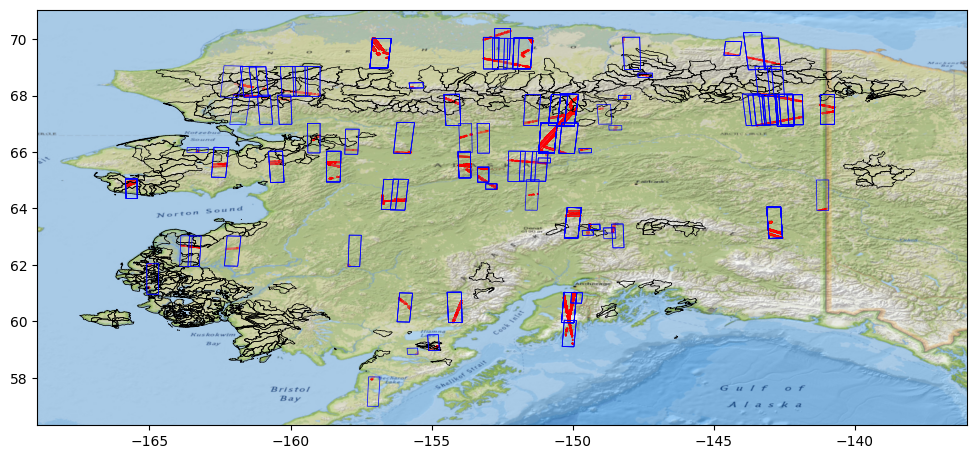

In [26]:
# Static map
xmin, ymin, xmax, ymax = lvis_pred_SUBSET.total_bounds
ax = tte_patterns_abrupt.to_crs(lvis_pred_SUBSET.crs).cx[xmin:xmax, ymin:ymax].to_crs(4326).boundary.plot(ec='k', linewidth=0.5, figsize=(12,10))
ax = footprint_gdf_preds_SUBSET_lvis_SUBSET.to_crs(lvis_pred_SUBSET.crs).to_crs(4326).boundary.plot(ec='blue', linewidth=0.5, ax=ax)
ax = lvis_pred_SUBSET.to_crs(4326).plot(ax = ax, ec='red', alpha=0.25, column='file')
ax = ctx.add_basemap(ax, crs=4326, source = maplib.basemap_xyz_url['esri_natgeo'],attribution=' ')

In [52]:
footprint_gdf_preds_SUBSET_lvis_SUBSET.explore(height='25%')

### Write out LVIS+prediction overlay gdf subset  

In [31]:
lvis_pred_SUBSET.iloc[0]

DN_1                                                            1.0
FILE_1            LVIS2_ABoVE2017_0714_R1803_082427_lvis_pt_cnt_...
PATH_1            /att/nobackup/pmontesa/userfs02/data/LVIS/2017...
file              WV02_20140705_M1BS_1030010032466E00-sr-02m.cnn...
footprint_name                  WV02_20140705_M1BS_1030010032466E00
path              /explore/nobackup/projects/ilab/projects/ABoVE...
area_km2                                                  17.760446
area_ha                                                 1776.044593
type                                                            CHM
catid                                              1030010032466E00
sensor                                                         WV02
year                                                           2014
month                                                             7
index_right                                                     509
DN_2                                            

In [49]:
lvis_pred_SUBSET.to_file(f'{dir_footprints}/footprint_overlay_lvis_{OUT_SUBDIR}_{SUBSET_TYPE}.gpkg', driver='GPKG')